<a href="https://colab.research.google.com/github/sclaudiobr/algoritmos-py/blob/master/GeoCloud02_Mapas_Tematicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GeoCloud 02 - Download de dados Temáticos do IBGE

Ferramenta para selecionar limites de municípios da base de dados do IBGE, através das biblioteca [geoBR](https://pypi.org/project/geobr/) e recortar o quadrante sobre os dados temáticos disponíveis nos geoserver do IBGE, através da biblioteca [WFs](https://inde.gov.br/). Neste  algoritmo foi aplicado sobre os temas Geologia, Geomorfologia, Solos e Vegetação. Ao final do processo uma pasta compactada é gerada para o download.

<hr>
@ autor Claudio Roberto Oliveira da Silva 
<p> Bel. Lic. Ciências Biológicas - UNL/AM - 2005
<p>MSc. Modelagem Computacional, Eng. Civil - COPPE/UFRJ - 2008
<p>Tecnólogo de Geoprocessamento, Cursando - UFSM - 2018
<p>email: <a href= "mailto:claumao@gmail.com"> claumao@gmail.com</a>
<p> Repositório: <a href="https://github.com/sclaudiobr/"> GitHub</a>

In [ ]:
!pip install geobr # Base de dados do IBGE, Malahas municipais, biomas, microrregiões, sedes
!pip install shapely # conversor e leitor de arquivos shp 
!pip install OWSLib # Acesso ao banco de dados WFS/WMS/OWS
!pip install pygeos # Biblioteca de apoio ao Geopandas
#------ Importa bibliotecas --------
import numpy as np
import geobr as br
import geopandas as gpd
import os
import owslib.wfs as ows
from owslib.wfs import WebFeatureService
from shapely.geometry import box
import zipfile
# --- cria diretório
!mkdir shp/

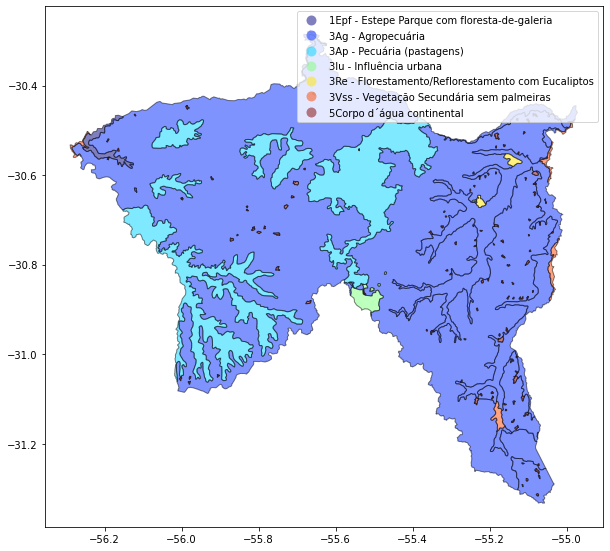

In [ ]:
### ---- FUNÇÃO BAIXAR DADOS -----------------------------
def gera_dados(uf,mun,id):
   df = br.read_municipality(code_muni=uf)
   df = df[df.name_muni==mun]
   #df.to_file('sm.geojson', driver='GeoJSON')
   dfbox = box(*df.total_bounds).bounds
   latitude,longitude = np.array(dfbox)[1],np.array(dfbox)[2]
   wfs_url = 'https://geoservicos.ibge.gov.br/geoserver/wfs'
   # Conectando ao serviço do GeoServer WFS.
   wfs = WebFeatureService(wfs_url, version='2.0.0')
   data = wfs.getfeature(typename=id, bbox=dfbox, outputFormat='JSON')
   fn = 'df.geojson'
   with open(fn, 'wb') as fh:
      fh.write(data.read())
   layers = gpd.read_file(fn)
   recorte = gpd.clip(layers, df,keep_geom_type=False)
   recorte.to_file('shp/df.shp', driver='ESRI Shapefile')

# ----- FUNÇÃO COMPACTA PASTAS
def zip(src, dst):
    zf = zipfile.ZipFile("%s.zip" % (dst), "w", zipfile.ZIP_DEFLATED)
    abs_src = os.path.abspath(src)
    for dirname, subdirs, files in os.walk(src):
        for filename in files:
            absname = os.path.abspath(os.path.join(dirname, filename))
            arcname = absname[len(abs_src) + 1:]
            print('zipping %s as %s' % (os.path.join(dirname, filename), arcname))
            zf.write(absname, arcname)
    zf.close()

# Identficadores
geo = 'CREN:Geologia_area_Brasil'
geom = 'CREN:brasil_geom_area'
ped = 'CREN:Pedologia_area_Brasil'
veg = 'CREN:vegetacao_area_brasil'

#### TROCA OS DADOS AQUI ########################
UF = 'RS'                       # <---- Estado aqui
mun = "Sant'ana Do Livramento"  #<--- Municipio Aqui (nome com acentuação)
camada = veg                    # <-- Camada de dados id (veg,geo,geom,ped)
nome_do_zip = 'vegetacao'       # <-  (nome sem acento)
#############################################
gera_dados(UF,mun,camada)
zip("projeto",nome_do_zip)

# Plotando o mapa
gdf =gpd.read_file('shp/df.shp')
gdf.plot(figsize=(10,10), alpha=0.5, edgecolor='k', cmap="jet",column='legenda', legend=True)